In [1]:
import pandas_datareader as pdr
from utils import *
import os
import time
import numpy as np
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.dates as mdates
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import BatchNormalization,Bidirectional,TimeDistributed,Dense,Input,Conv2D,MaxPool1D,Activation,Dropout,Flatten,Conv1D,concatenate,Embedding,LSTM
# from tensorflow.compat.v1.keras.layers import CuDNNLSTM
import tensorflow as tf
from sklearn.externals import joblib 
from tensorflow.keras.initializers import he_normal,glorot_normal,he_uniform
from tensorflow.keras.utils import to_categorical

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
from datetime import timedelta, date
# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from math import log, sqrt, pi, exp
from scipy.stats import norm
from datetime import datetime, date
import numpy as np
import pandas as pd
from pandas import DataFrame

C:\Users\harsh\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
related_companies = ['AMD','INTC','NVDA','MSFT','QCOM','TSM','SPY']
future_data = []

Test Data Pipeline:

    Step 1: We will loop over the list_of_companies
    Step 2: For the purpose of real time, we are only taking the test data from Jan 1st to May 31st, that means we are assuming the present day is May 31st. And we dont have the data for June 2020, so we will generate data from our predictions i.e from 7 models
    Step 3: We have written loop that runs from June 1st to June 31st 2020(only trading days, weekends are excluded)
    Step 4: First we take the test data we already that i.e Jan 2020 to May 2020
    Step 5: We will perform technical feature engineering part for the data
            Now we have Target Company closing Price and few technical features
    Step 6: We add the closing price from the related_companies, except the target company
            Ex: When we want to predict for AMD , 'INTC','NVDA','MSFT','QCOM','TSM','SPY'
    Step 7: We will use the scalar funtions which were trained during training phase(please note its just sacalar.transform not scalar.fit_transform)
    Step 8: We transform the data into time series dataset
    Step 9: We load the model and predict the stock price, this will be done for each and every company
    Step 10: Now we have our predictions of each company for June 1st 2020, we use these predictions as data for predicting June 2nd data and so on ...
    Step 11: We plot the predictionswith actual data

In [3]:
def test_data_predictor(list_of_companies,number_of_days):
    # Fetching data from Jan 1st only till May 31st 2020
    for company in list_of_companies:
        # Loop 1 AMD
        for stock_name in list_of_companies:
            # Loop to select all the related companies
            if not os.path.isfile("Data_test/"+ stock_name + '.csv'):
#                 if os.path.dirname('Data_test'):
#                     pass
#                 else:
#                     os.mkdir("Data_test")               
                df = pdr.get_data_tiingo(symbols=[stock_name],start='1/1/2020',end = '05/31/2020', api_key='bc41cd89fc117b78bbde26797c2f1b72b7aa83c2')
                df.to_csv( "Data_test/"+ stock_name + '.csv')
                df = pd.read_csv("Data_test/"+ stock_name + '.csv')
                df['date'] = pd.to_datetime(df['date'])
                df['date'] = df['date'].apply(lambda x: x.date())
                df.to_csv( "Data_test/"+ stock_name + '.csv')
            elif stock_name == company:
                company_df = pd.read_csv('Data_test/' + company + '.csv')
            else:
                pass
    
        def daterange(start_date, end_date):
            for n in range(int((end_date - start_date).days)):
                yield start_date + timedelta(n)
# #         Reading the data
#         df = pdr.get_data_tiingo(symbols=[stock_name],start=prediction_start,end = prediction_end, api_key='bc41cd89fc117b78bbde26797c2f1b72b7aa83c2')
#         df.to_csv( "Data_test/"+ stock_name + '.csv')
#         df = pd.read_csv("Data_test/"+ stock_name + '.csv')
#         df['date'] = pd.to_datetime(df['date'])
#         df['date'] = df['date'].apply(lambda x: x.date())

    # Selecting data from June 1st 2020
    for index,single_date in enumerate(range(number_of_days)):
        # single_date will loop from June 1st to June 31st 2020
        
        # For each loop we have to predict for each company, so in this case we have 7 companies.
        future_data = []
        for stock_name in list_of_companies:
            # Reading the data and performing all the necessary pre-processing
            company_df = pd.read_csv('Data_test/' + stock_name + '.csv',index_col=0)

            company_df = company_df[['close']]

            def technical_indicators(df):
                # Moving Average
                df['week_moving_avg'] = df['close'].rolling(window=7,min_periods=1).mean()
                df['21d_moving_avg'] = df['close'].rolling(window=21,min_periods=1).mean()

                # MACD
                df['12_ema'] = df[['close']].ewm(span=12).mean()
                df['26_ema'] = df[['close']].ewm(span=26).mean()
                df['macd'] = df['12_ema'] - df['26_ema']

                # Bollinger Bands
                df['20_day_std'] = df['close'].rolling(window=20,min_periods=0).std()
                df['upper_band'] = df['21d_moving_avg'] + (df['20_day_std']*2)
                df['lower_band'] = df['21d_moving_avg'] - (df['20_day_std']*2)

                return df

            company_df = technical_indicators(company_df)

            close_fft = np.fft.fft(np.asarray(company_df['close'].tolist()))
            fft_df = pd.DataFrame({'fft':close_fft})
            company_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
            company_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))
#             company_df = pd.concat([company_df,fft_df],axis=1)

#             company_df = company_df.drop(['fft'],axis=1)

            for others in list_of_companies:
                if others == stock_name:
                    pass
                else:
                    temp_df = pd.read_csv("Data_test/"+ others + '.csv')
                    company_df[others] = temp_df['close']

            nan_features = ['20_day_std','upper_band','lower_band']
            
            for fill_na in nan_features:
                company_df[fill_na] = company_df[fill_na].fillna(company_df[fill_na][1])

#             if index == 0:
#                 pass
#             else:


            company_df['target'] = company_df['close']
            company_df = company_df.drop(['close'],axis=1)
        # Loading the scalar funtion for respective company
            scalar = joblib.load('min_max_scaler_' + stock_name + '.pkl') 
            
            company_df_scale = scalar.transform(company_df)
        # Transforming the data into time series data
            def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
                n_vars = 1 if type(data) is list else data.shape[1]
                df = pd.DataFrame(data)
                cols, names = list(), list()
                # input sequence (t-n, ... t-1)
                for i in range(n_in, 0, -1):
                    cols.append(df.shift(i))
                    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
                # forecast sequence (t, t+1, ... t+n)
                for i in range(0, n_out):
                    cols.append(df.shift(-i))
                    if i == 0:
                        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                    else:
                        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
                # put it all together
                agg = pd.concat(cols, axis=1)
                agg.columns = names
                # drop rows with NaN values
                if dropnan:
                    agg.dropna(inplace=True)
                return agg

            time_series_data = series_to_supervised(company_df_scale, 20,50)
            # Model Parameters
            past_time = 70
            no_of_features = 17
            observation_set = past_time * no_of_features
            test_X, test_y = time_series_data.values[:, :observation_set], time_series_data.values[:, -1]

            test_X = test_X.reshape(test_X.shape[0], past_time,no_of_features)
            tf.keras.backend.clear_session()
            # Loading the model for respective target company
            model = tf.keras.models.load_model('time_series_model_' + stock_name + '.h5')
            # Predicting the available data
            predicted = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0]),observation_set)
            
            result_predicted = np.concatenate([test_X[:,-(no_of_features-1):],predicted],axis=1)

            result_predicted = scalar.inverse_transform(result_predicted)
            # Only considering the last predicted value
            predicted = result_predicted[:,-1]

        
            future_data.append(predicted[-1])
            # Once we get the prected value for each company we stack it with the already available data.
        for index,stock_name in enumerate(list_of_companies):
            company_df = pd.read_csv('Data_test/' + stock_name + '.csv',index_col=0)

            company_df_list = [i for i in company_df['close']]
            company_df_list.append(future_data[index])
            temp_df = pd.DataFrame()
            temp_df['close'] = company_df_list
            # Saving the dataframe( already available data +new predictions)
            temp_df.to_csv('Data_test/' + stock_name + '.csv')


In [4]:
test_data_predictor(related_companies,number_of_days=20)

In [5]:
def technical_indicators(df):
  # Moving Average
  df['week_moving_avg'] = df['close'].rolling(window=7,min_periods=1).mean()
  df['21d_moving_avg'] = df['close'].rolling(window=21,min_periods=1).mean()

  # MACD
  df['12_ema'] = df[['close']].ewm(span=12).mean()
  df['26_ema'] = df[['close']].ewm(span=26).mean()
  df['macd'] = df['12_ema'] - df['26_ema']
  
  # Bollinger Bands
  df['20_day_std'] = df['close'].rolling(window=20,min_periods=0).std()
  df['upper_band'] = df['21d_moving_avg'] + (df['20_day_std']*2)
  df['lower_band'] = df['21d_moving_avg'] - (df['20_day_std']*2)

  return df
def plotter(stock_name):
    if not os.path.isfile("Data_real_test/"+ stock_name + '.csv'):
        if os.path.dirname('Data_real_test'):
            pass
        else:
            os.mkdir("Data_real_test")
        df_real = pdr.get_data_tiingo(symbols=[stock_name],start='01/01/2020',end = '06/27/2020', api_key='bc41cd89fc117b78bbde26797c2f1b72b7aa83c2')
        df_real.to_csv( "Data_real_test/"+ stock_name + '.csv')
        df_real = pd.read_csv("Data_real_test/"+ stock_name + '.csv')
        df_real['date'] = pd.to_datetime(df_real['date'])
        df_real['date'] = df_real['date'].apply(lambda x: x.date())
        df_real.to_csv( "Data_real_test/"+ stock_name + '.csv')
    else:
        company_df_real = pd.read_csv('Data_real_test/' + stock_name + '.csv')
    if not os.path.isfile("Data_test/"+ stock_name + '.csv'):
        if os.path.dirname('Data_test'):
            pass
        else:
            os.mkdir("Data_test")        
        df_pred = pdr.get_data_tiingo(symbols=[stock_name],start='1/1/2020',end = '05/31/2020', api_key='bc41cd89fc117b78bbde26797c2f1b72b7aa83c2')
        df_pred.to_csv( "Data_test/"+ stock_name + '.csv')
        df_pred = pd.read_csv("Data_test/"+ stock_name + '.csv')
        df_pred['date'] = pd.to_datetime(df_pred['date'])
        df_pred['date'] = df_pred['date'].apply(lambda x: x.date())
        df_pred.to_csv( "Data_test/"+ stock_name + '.csv')
    elif stock_name == stock_name:
        company_df_pred = pd.read_csv('Data_test/' + stock_name + '.csv')
    else:
        pass
    plt.figure(figsize=(20,3))
    plt.title('{} Real Stock Price Vs Predicted Price'.format(stock_name))
    plt.plot(company_df_real['date'][103:],company_df_pred['close'][-20:],label = 'Predicted')
    plt.plot(company_df_real['date'][103:],company_df_real['close'][103:],label = 'Real Data')
    company_df_pred = technical_indicators(company_df_pred)
    company_df_real = technical_indicators(company_df_real)            
    plt.xticks(rotation=90)

    plt.legend()
    plt.show()
    print('{} RMSE Value: {}'.format(stock_name,np.sqrt(mean_squared_error(company_df_pred['close'][-20:],company_df_real['close'][103:]))))
    return company_df_real,company_df_pred

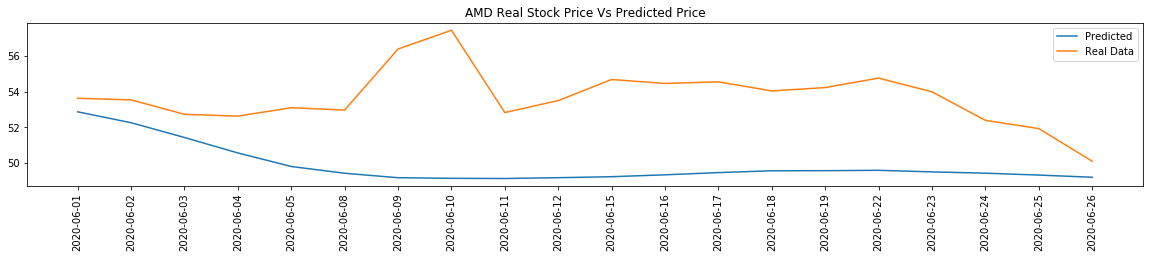

AMD RMSE Value: 4.3082407475931195


In [6]:
real_data, predicted_data = plotter(stock_name='AMD')

In [58]:
real_data['real_data'] = real_data['close']
predicted_data['predicted_data'] = predicted_data['close']

final_df = pd.concat([real_data,predicted_data],axis=1)

In [66]:
final_df = final_df[['date','real_data','predicted_data']].tail(20)

In [67]:
final_df

,date,real_data,predicted_data
103,2020-06-01,53.63,52.870812
104,2020-06-02,53.54,52.259774
105,2020-06-03,52.73,51.432149
106,2020-06-04,52.63,50.565838
107,2020-06-05,53.10,49.807391
108,2020-06-08,52.97,49.428191
109,2020-06-09,56.39,49.178650
110,2020-06-10,57.44,49.144953
111,2020-06-11,52.83,49.134000
112,2020-06-12,53.50,49.179886


In [70]:
from __future__ import division
from scipy.stats import norm
from math import *

# Cumulative normal distribution
def CND(X):
    return norm.cdf(X)

# Black Sholes Function
def BlackScholes(CallPutFlag,S,K,t,r,s):
    """
    S = Current stock price
    t = Time until option exercise (years to maturity)
    K = Option striking price
    r = Risk-free interest rate
    N = Cumulative standard normal distribution
    e = Exponential term
    s = St. Deviation (volatility)
    Ln = NaturalLog
    """
    d1 = (log(S/K) + (r + (s ** 2)/2) * t)/(s * sqrt(t))
    d2 = d1 - s * sqrt(t)
    if CallPutFlag=='c':
        return S * CND(d1) - K * exp(-r * t) * CND(d2) # call option
    else:
        return K * exp(-r * t) * CND(-d2) - S * CND(-d1) # put option

In [82]:
call_price = []
put_price = []
for time_to_stike in range(20):
    time_to_stike_years = (30 - time_to_stike)/360
    current_date_index = 103 + time_to_stike
    price_std_dev = np.std(final_df['predicted_data'])
    
    call_price.append(BlackScholes(CallPutFlag = 'c',\
                                   S=final_df['predicted_data'][current_date_index],\
                                   K=50,t=time_to_stike_years,r=0.0165,s= price_std_dev))
    put_price.append(BlackScholes(CallPutFlag = 'p',\
                                  S=final_df['predicted_data'][current_date_index],K=50,\
                                  t=time_to_stike_years,r=0.0165,s= price_std_dev))
    

In [83]:
final_df['call_prices'] = call_price
final_df['put_prices'] = put_price


In [84]:
final_df

,date,real_data,predicted_data,call_price,call_prices,put_prices
103,2020-06-01,53.63,52.870812,10.722117,7.767467,4.827952
104,2020-06-02,53.54,52.259774,10.452037,7.282414,4.956226
105,2020-06-03,52.73,51.432149,10.090738,6.674738,5.178463
106,2020-06-04,52.63,50.565838,9.718182,6.061176,5.433501
107,2020-06-05,53.10,49.807391,9.396804,5.526654,5.659716
108,2020-06-08,52.97,49.428191,9.237821,5.210828,5.725379
109,2020-06-09,56.39,49.178650,9.133820,4.966705,5.733085
110,2020-06-10,57.44,49.144953,9.119813,4.836301,5.638667
111,2020-06-11,52.83,49.134000,9.115263,4.715524,5.531132
112,2020-06-12,53.50,49.179886,9.134333,4.621979,5.393991
